# _Can machine learning algorithms predict if a persons' wage is enough to live? Evidence from socio-demographic data of Chilean individuals_


**Joaquin Perez-Lapillo**

Principles of Data Science<br>
MSc in Data Science<br>
City, University of London

***




### Step 1: Import libraries and data

In [1]:
# Importing libraries and defining style
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
#%matplotlib inline

# Importing data
df = pd.read_csv('casen2017.csv', engine='python')
print(df.shape)

(216439, 804)


The entire dataset includes 216,439 observations and 804 columns. Most of the columns are questions that help build aggregates such as 'total income' or 'salary'. For that reason, we are going to select just a few of those for the study.

### Step 2: Selecting variables for analysis

In [2]:
# Filtering variables
cols = ['ecivil','region','zona','sexo','edad','esc','activ','r3','o10','o12','o15',
        'o13','o28','oficio1','rama1','y27b','s13','ytrabajocor']

df_filter = df.filter(cols)
print(df_filter.shape)

# Rename variables
df_filter = df_filter.rename(columns={'ecivil': 'maritalst', 'ytrabajocor': 'income', 'zona': 'zone', 'sexo': 'sex',
                                      'edad': 'age','esc':'education','r3': 'ethni','o12':'jobtype','o13':'year',
                                      'o15': 'sector','rama1':'industry','oficio1': 'position', 'o28':'socsec',
                                      'y27b':'bankacc','s13':'health', 'o10':'hours'})

(216439, 18)


We will work with 17 features and 1 target variable ('income'). An important number of the independant variables are categorical, so we first need to declare them as it.

In [3]:
# Declaring list of categorical variables into 'type: categorical'
cat_cols = ['maritalst','region','zone','sex','ethni','jobtype','sector','socsec','position','industry','bankacc','health']
df_filter[cat_cols] = df_filter[cat_cols].astype('category')
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216439 entries, 0 to 216438
Data columns (total 18 columns):
maritalst    216439 non-null category
region       216439 non-null category
zone         216439 non-null category
sex          216439 non-null category
age          216439 non-null int64
education    174058 non-null float64
activ        175076 non-null float64
ethni        216439 non-null category
hours        92296 non-null float64
jobtype      92417 non-null category
sector       92417 non-null category
year         92417 non-null float64
socsec       175076 non-null category
position     92417 non-null category
industry     92417 non-null category
bankacc      175076 non-null category
health       216439 non-null category
income       97235 non-null float64
dtypes: category(12), float64(5), int64(1)
memory usage: 12.4 MB


### Step 3: Initial processing

**3.1.** Keeping active workers: The dataset includes some individuals without income and some that are not currently in the labor market. Because of the scope of the study, we need to drop them to keep only active workers.

In [4]:
# Deleting observations without income and not currently in the labor market
df_imp = df_filter[pd.notnull(df_filter['income'])]
df_imp = df_imp[df_imp['activ']==1]
del df_imp['activ']

print(df_imp.shape)
df_imp.head()

(90517, 17)


,maritalst,region,zone,sex,age,education,ethni,hours,jobtype,sector,year,socsec,position,industry,bankacc,health,income
0,8,1,1,2,56,12.0,1,8.0,1.0,2.0,1994.0,2.0,9.0,7.0,2.0,4,250000.0
1,8,1,1,2,21,7.0,10,59.0,1.0,7.0,2015.0,2.0,9.0,16.0,2.0,5,200000.0
2,2,1,1,1,24,12.0,10,8.0,1.0,5.0,2016.0,1.0,5.0,8.0,9.0,4,281750.0
3,2,1,1,1,28,12.0,10,8.0,1.0,5.0,2017.0,2.0,5.0,8.0,9.0,4,311750.0
4,1,1,1,1,26,15.0,10,8.0,1.0,5.0,2016.0,1.0,9.0,16.0,9.0,9,341667.0


The resulting dataset has 90,517 observations.

**3.2** Obtaining 'years of experience': the dataset includes a variable 'year' which is the year the individual started working on his current occupation. Hence, we need some transformations.

In [5]:
# 'year' inidcates the year the individual started working. Printing some descriptive statistics
print(df_imp.year.describe())

# First, we see that there are some observations with year='9999' that we have to replace
# In this case, we decide to use the median (2013) because the mean is being seriously affected by outliers
df_imp.year.replace([9999], [df_imp['year'].median()], inplace=True)

# Creating a new variable 'exp' = years of experience
df_imp['experience'] = 2018 - df_imp['year']

# Print to check outcome
print('-'*40)
print(df_imp.experience.describe())

# Deleting the original variable
del df_imp['year']

# To check for outliers: comparing age and experience
df_imp['check'] = df_imp['age'] - df_imp['experience']
print('-'*40)
print(df_imp.check.describe())

# Deleting individuals that started working before they were 15 years old
df_imp = df_imp[(df_imp.check >= 15)]
del df_imp['check']

count    90517.000000
mean      2052.734437
std        590.533664
min       1930.000000
25%       2006.000000
50%       2013.000000
75%       2016.000000
max       9999.000000
Name: year, dtype: float64
----------------------------------------
count    90517.000000
mean         9.114144
std         10.643742
min          0.000000
25%          2.000000
50%          5.000000
75%         12.000000
max         88.000000
Name: experience, dtype: float64
----------------------------------------
count    90517.000000
mean        34.110929
std         12.904375
min        -44.000000
25%         24.000000
50%         32.000000
75%         43.000000
max         98.000000
Name: check, dtype: float64


**3.3** Creating a categorical target variable using the Chilean living wage as a threshold

In [6]:
# Creating a categorical target variable:
# income_cat=0 --> less than the living wage ; income_cat=1 --> more than the living wage
df_imp['income_cat'] = 0
living_wage = 400000
df_imp['income_cat'] = np.where(df_imp['income'] >= living_wage,1,0)

### Step 4: Dealing with missing values and outliers

In [7]:
# Missing values report
print(df_imp.isnull().sum())

maritalst       0
region          0
zone            0
sex             0
age             0
education     553
ethni           0
hours         106
jobtype         0
sector          0
socsec          0
position        0
industry        0
bankacc         0
health          0
income          0
experience      0
income_cat      0
dtype: int64


We see that only 'education' and 'hours' have missing values.

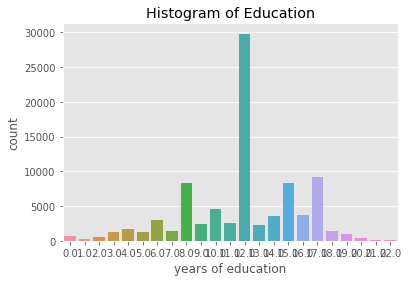

In [8]:
# Plotting education to explore alternatives to addressing missing values:
sns.countplot(x='education',data=df_imp)
plt.title('Histogram of Education')
plt.xlabel('years of education')
plt.show()

In [9]:
# Because education has a clear mode, the choise will be to fill missings with '12'. 
df_imp['education'] = df_imp['education'].fillna(12)

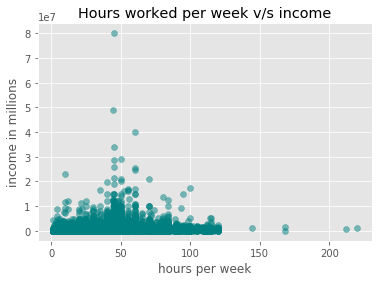

--------------------------------------------------
Summary statistics: hours worked per week
________________________________________
count    88689.000000
mean        42.954741
std         14.682977
min          1.000000
25%         40.000000
50%         45.000000
75%         45.000000
max        220.000000
Name: hours, dtype: float64


In [10]:
# Plotting weekly hours worked to explore alternatives to addressing missing values:
plt.scatter(df_imp['hours'], df_imp['income'], color='teal', alpha=0.5)
plt.title('Hours worked per week v/s income')
plt.xlabel('hours per week')
plt.ylabel('income in millions')
plt.show()
print('-'*50)
print('Summary statistics: hours worked per week')
print('_'*40)
print(df_imp.hours.describe())

We see that most people work 45 hours per week, and that there are some outliers to deal with. To do that, we define a limit of 72 hours worked as a valid number (12 hours per day, monday to saturday).

In [11]:
# Replacing missing values and outliers of 'hours' with the median (45)
df_imp['hours'] = df_imp['hours'].fillna(45)
df_imp['hours'] = np.where(df_imp['hours'] >= 72,45,df_imp['hours'])

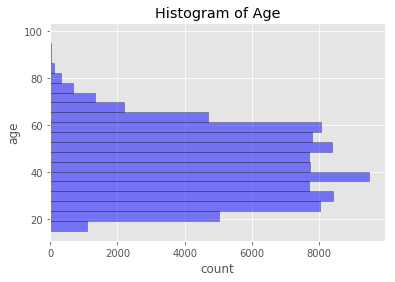

In [12]:
# Plotting age to check for outliers:
plt.hist('age',data=df_imp, bins=20,color='b',orientation = 'horizontal',alpha=0.5,ec='black')
plt.title('Histogram of Age')
plt.xlabel('count')
plt.ylabel('age')
plt.show()

There is people over 75 years old classified as active workers, which is unlikely to happen. We decide to drop those observations to keep only relevant observations.

In [13]:
# As we are considering only active people, observations with age > 70 will be deleted
df_imp = df_imp[df_imp['age'] <= 70]
df_imp.shape

(86697, 18)

The final dataset includes 86,697 observations, without outliers or missings and keeping only observations that are relevant to the problem of the study. 

### Step 5: Performing Visual Exploratory Data Analysis

**5.1** Describing the income distribution for Chilean individuals

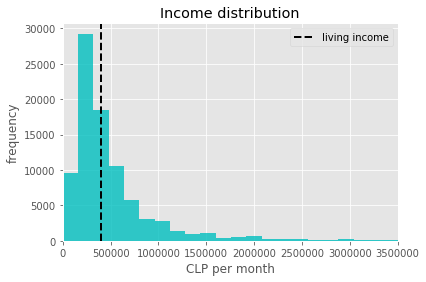

In [14]:
# Income distribution
plt.hist(df_imp.income, bins=500, alpha=0.8, color='c')
plt.title('Income distribution')
plt.ylabel('frequency')
plt.xlabel('CLP per month')
plt.xlim(0,3500000)
plt.axvline(400000, color='k', linestyle='dashed', linewidth=2, label='living income')
plt.legend()
plt.show()

We see a clear right skewed distribution. The black dashed line shows the living wage of $400k defined.

In [15]:
# To see how are the two categories represented in the dataset (minority/mayority class ratio)
count = df_imp.income_cat.value_counts()
print('Minority class (income_cat == 1):', round(count[1]/(count[0]+count[1])*100,1),'%')

Minority class (income_cat == 1): 45.1 %


Individuals that earn more than the living wage represent 45.5 % of total. Hence, we say that the dataset is relatively balanced.

**5.2** Exploring correlation between income and continuous variables and their distributions over the two target groups

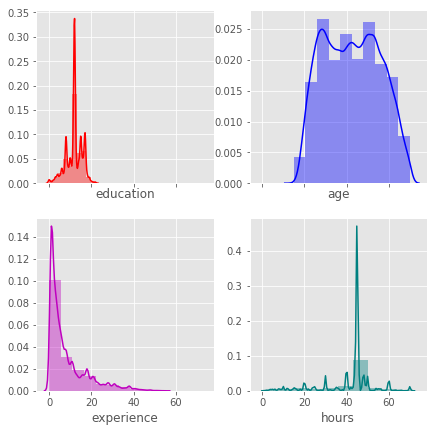

In [16]:
# Plotting histograms of continuous variables: education, age, hours and experience
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(df_imp["education"],color='r',ax=axes[0, 0],bins=10)
sns.distplot(df_imp["age"],color='b', ax=axes[0, 1],bins=10)
sns.distplot(df_imp["experience"],color='m',ax=axes[1, 0],bins=10)
sns.distplot(df_imp["hours"],color='teal',ax=axes[1, 1],bins=10)
plt.show()

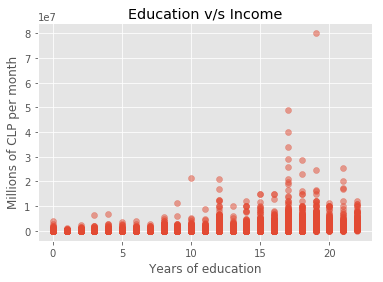

Pearsons:  0.32 ; Spearmans: 0.47 .


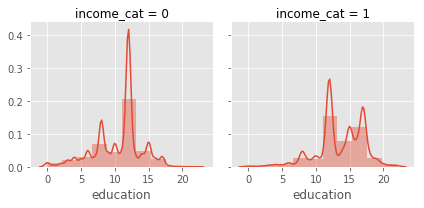

In [17]:
# Plotting education versus income
plt.scatter(df_imp.education, df_imp.income,alpha=0.5)
plt.title('Education v/s Income')
plt.xlabel('Years of education')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.education, df_imp.income)
spearman = stats.spearmanr(df_imp.education, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Education versus income category
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'education', bins=10)
plt.show()

Education v/s Income:
- Correlation coefficients (Pearsons=0.32 ; Spearmans=0.47) tell us that there is a relatively strong positive correlation between education and income. The gap between them shows that the relationship is not linear but most probably quadratic.
- For the first group (income_cat=0), there are clear peaks at 8 and 12 years of education (elementary and high school), whereas for the second one (income_cat=1) the peaks are at 12, 15 and 17 years (high school, college and university). Thus, we conclude that the probability distributions of both groups are different.

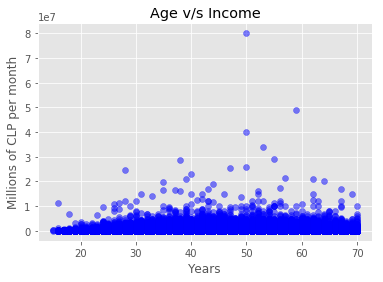

Pearsons:  0.03 ; Spearmans: -0.01 .


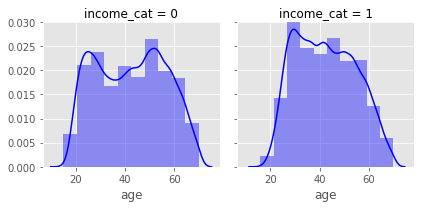

In [18]:
# Plotting age versus income
plt.scatter(df_imp.age, df_imp.income,alpha=0.5, color='b')
plt.title('Age v/s Income')
plt.xlabel('Years')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.age, df_imp.income)
spearman = stats.spearmanr(df_imp.age, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Age versus income categories
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'age',color='blue', bins=10)
plt.show()

Age v/s Income:
- Since correlation coefficients (Pearsons=0.04 ; Spearmans=0.01) are close to zero, we conclude that there is no correlation between age and income. 
- But, we see different distributions since the first group (income_cat=0) shows a bimodal distribution with peaks at 20 and 50 years, meanwhile the second one (income_cat=1) has only one peak at around 30.

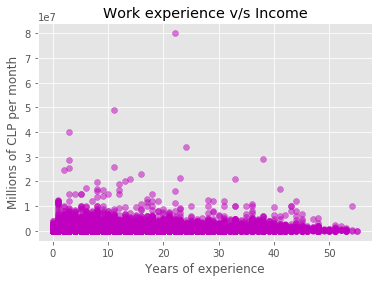

Pearsons:  0.11 ; Spearmans: 0.19 .


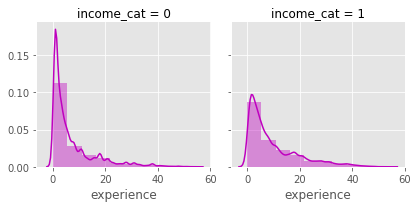

In [19]:
# Plotting work experience versus income
plt.scatter(df_imp.experience, df_imp.income,alpha=0.5, color='m')
plt.title('Work experience v/s Income')
plt.xlabel('Years of experience')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.experience, df_imp.income)
spearman = stats.spearmanr(df_imp.experience, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Experience versus income categories
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'experience',color='m',bins=10)
plt.show()

Experience v/s Income:
- Since correlation coefficients (Pearsons=0.11 ; Spearmans=0.20) are relatively low, we conclude that there is a weak positive correlation between work experience and income.
- Both groups show right skewed distributions, but group 0 show less kurtosis. This means that there are more chances to earn less than the living wage having little work experience.

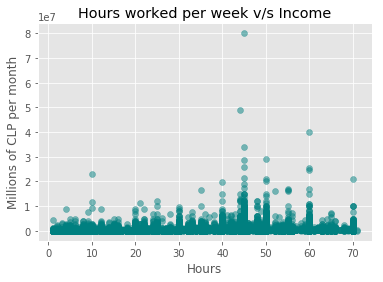

Pearsons:  0.12 ; Spearmans: 0.23 .


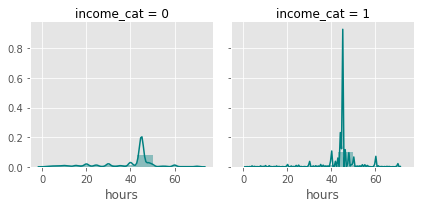

In [20]:
# Plotting Hours worked versus income
plt.scatter(df_imp.hours, df_imp.income,alpha=0.5, color='teal')
plt.title('Hours worked per week v/s Income')
plt.xlabel('Hours')
plt.ylabel('Millions of CLP per month')
plt.show()

# Correlation coefficients
pearson = stats.pearsonr(df_imp.hours, df_imp.income)
spearman = stats.spearmanr(df_imp.hours, df_imp.income)
print('Pearsons: ',round(pearson[0],2),'; Spearmans:',round(spearman[0],2),'.')

# Hours worked versus income categories
g = sns.FacetGrid(df_imp, col='income_cat')
g = g.map(sns.distplot, 'hours',color='teal',bins=10)
plt.show()

Hours worked v/s Income:
- Since correlation coefficients (Pearsons=0.12 ; Spearmans=0.23) are relatively low, we conclude that there is a weak positive correlation between work experience and income.
- Both group's distributions are centered in 45 hours, but income_cat=1 has lower kurtosis. This means that it is more likely to overcome the threshold when individuals work 45 hors a week.

**5.3** Correlation matrix: explore relationships between continuous features

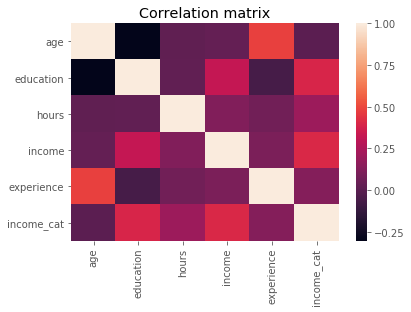

In [21]:
# Correlation matrix
sns.heatmap(df_imp.corr())
plt.title('Correlation matrix')
plt.show()

Some observations:
- There is a negative correlation between age and education, meaning that young workers are more educated than older workers. This make sense considering that access to universities in Chile was significantly expanded after a reform in 2005.
- There is a strong possitive correlation between age and experience.
- No significant correlation between hours worked and other continuous variables.

**5.4** Performing EDA over categorical variables

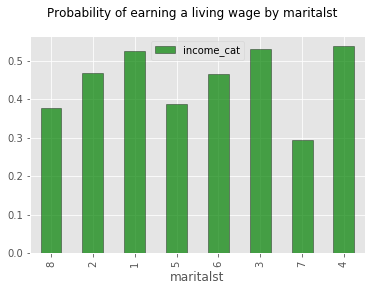

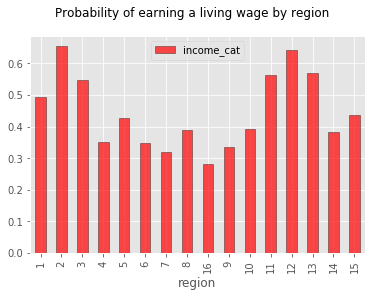

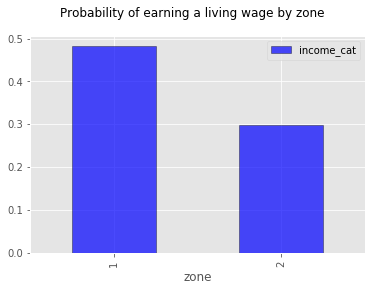

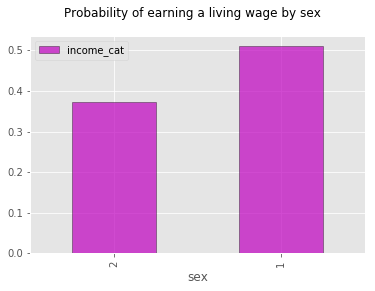

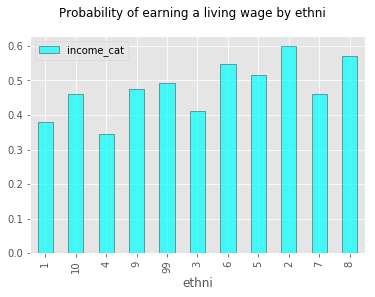

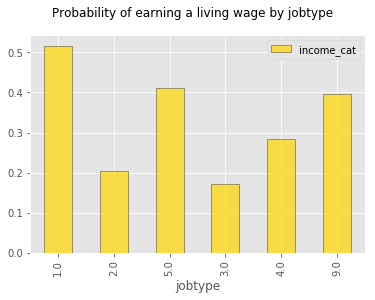

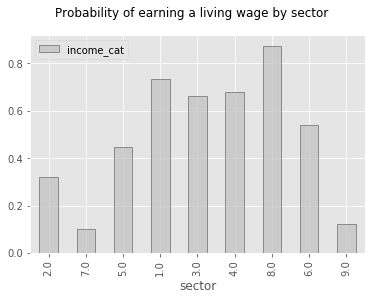

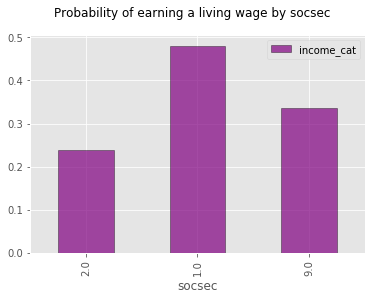

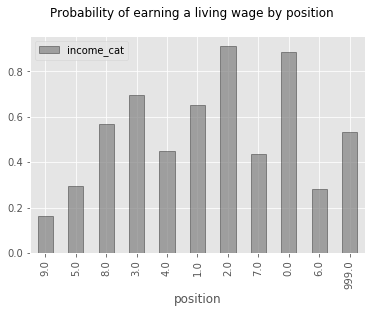

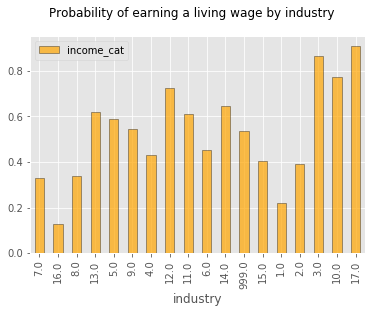

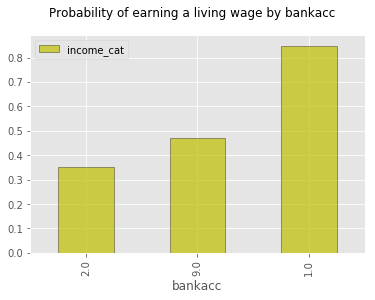

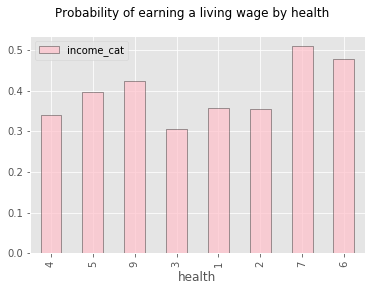

In [22]:
# Plotting categorical variables
colors = ['g','r','b','m','cyan','gold','silver','purple','grey','orange','y','pink']
# defining a function to iterate over
def plot_vars(column, color):
    var_pivot = df_imp.pivot_table(index=column,values='income_cat')
    var_pivot.plot.bar(color=color,alpha=0.7,ec='black')
    plt.suptitle('Probability of earning a living wage by {}'.format(column))
    plt.show()
    
# calling the function on all categorical variables
for i in range(12):
    plot_vars(cat_cols[i],colors[i])

Observations on categorical variables: <br>
- Characteristics of individuals that are **more likely** to earn a living wage:
    - Men (sex=1)
    - Married (maritalst=1)
    - Living in extreme regions (region={1,2,3,11,12}) and the capital (13)
    - Having a permanent-full time contract (jobtype=1)
    - Working for the government (sector={3,4}), armed forces (8) or own a business (1)
    - Having a social security savings account (socsec=1)
    - Professionals (position=2), military (0) and technicians (3)
    - Working in mining (industry=3), financial companies (10) and government (12, 17)
    - Having a current bank account (bankacc=1)
    - People that declare being in good health condition (health={6,7})


- Characteristics of individuals that are **less likely** to earn a living wage:
    - Women (sex=2)
    - Single (maritalst=8)
    - Living in the center regions of the country (region={4,5,6,7,8,9,10})
    - Having a part-time contract (jobtype={2,5})
    - Being self-employed(sector=2)
    - Not having a social security savings account (socsec={2,9})
    - Salespersons (position=5), operators (7), farmers (6) and having no qualifications (9)
    - Working in farming (industry=1), fishing (2) and retail companies (7)
    - Not having a bank account (bankacc={2,9})
    - People that declare being in a poor health condition (health=~{6,7})
 

### Step 6: Data preparation for ML algorithms

**6.1** Deleting original income column since our task will be classification

In [23]:
# deleting original income column
del df_imp['income']

**6.2** Create a dummy dataset: because one of the models that will be used to perform classification is Logistic Regression, we need to create an alternative dataset in the 'long' format. This means that we need to create dummy variables for each categorical variable state.

In [24]:
# Transforming categorical variables into dummies, then deleting original variables
dummies = pd.get_dummies(df_imp[cat_cols], prefix=cat_cols)
df_imp_dum = pd.concat([df_imp,dummies], axis=1)
df_imp_dum = df_imp_dum.drop(cat_cols, 1)
df_imp_dum.head()

,age,education,hours,experience,income_cat,maritalst_1,maritalst_2,maritalst_3,maritalst_4,maritalst_5,...,bankacc_2.0,bankacc_9.0,health_1,health_2,health_3,health_4,health_5,health_6,health_7,health_9
0,56,12.0,8.0,24.0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,21,7.0,59.0,3.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,24,12.0,8.0,2.0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,28,12.0,8.0,1.0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,26,15.0,8.0,2.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


**6.3** Scaling and performing PCA: the resulting dataset with dummy variables has 102 columns. We will continue by trying PCA as an alternative to reduce dimensionality. But before that, we need to transform all variables to the same scale.

In [25]:
# Scaling variables
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df_imp_dum_scal = min_max_scaler.fit_transform(df_imp_dum)
df_imp_dum_scal = pd.DataFrame(df_imp_dum_scal)
# deleting target variable
del df_imp_dum_scal[4]

In [26]:
# Performing PCA to reduce dimensionality
from sklearn.decomposition import PCA
# model with 2 components
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df_imp_dum_scal)
var_exp = pca.explained_variance_ratio_
print(var_exp)
total = 0
for i in var_exp:
    total = total + i
print('-'*70)
print('Total variance explained by PCA:', round(total,2)*100,'%')

[0.08390187 0.07139787 0.06292313 0.05154435 0.04610134 0.04430715
 0.03601322 0.0348621  0.03314961 0.03011748]
----------------------------------------------------------------------
Total variance explained by PCA: 49.0 %


We see that performing PCA to reduce dimensionality is not efficient since with 10 components we just explain 50% of the variance. Since the number of principal components needed to explain a significan ammount of the variance would be too high, we decide to run the algorithm with the original 102 variables.

**6.4** Train test split over the two alternative datasets (original and dummy)

In [27]:
# Train test split over original dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_imp, test_size=0.3, random_state=1)
# Defining predictors
train_predictors = train.columns[:16]
test_predictors = test.columns[:16]

In [28]:
# Train test split over dummy dataset
train_dum, test_dum = train_test_split(df_imp_dum, test_size=0.3, random_state=1)
# Defining predictors
train_dum_predictors = train_dum[list(train_dum.columns[0:4]) + list(train_dum.columns[5:])]
test_dum_predictors = test_dum[list(test_dum.columns[0:4]) + list(test_dum.columns[5:])]

### Step 7: Performing classification using ML algorithms

**7.1** Training different models: Naive Bayes, Decision trees, Random forest and Logistic regression

In [29]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb = GaussianNB()
nb_model = nb.fit(train[train_predictors], train['income_cat'])
nb_predictions = nb_model.predict(test[test_predictors])
nb_accuracy = accuracy_score(test['income_cat'], nb_predictions)
print('NB Accuracy:',round(nb_accuracy*100,1),'%')

NB Accuracy: 69.8 %


In [30]:
# Decision trees
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt_model = dt.fit(train[train_predictors], train['income_cat'])
dt_predictions = dt_model.predict(test[test_predictors])
dt_accuracy = accuracy_score(test['income_cat'], dt_predictions)
print('DT Accuracy:',round(dt_accuracy*100,1),'%')

DT Accuracy: 70.3 %


In [31]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=1)
rf_model = rf.fit(train[train_predictors], train['income_cat'])
rf_predictions = rf_model.predict(test[test_predictors])
rf_accuracy = accuracy_score(test['income_cat'], rf_predictions)
print('RF Accuracy:',round(rf_accuracy*100,1),'%')

RF Accuracy: 78.8 %


In [32]:
# Logistic regression (on dummy dataset)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(train_dum_predictors, train_dum['income_cat'])
lr_predictions = lr_model.predict(test_dum_predictors)
lr_accuracy = accuracy_score(test_dum['income_cat'], lr_predictions)
print('LR Accuracy:',round(lr_accuracy*100,1),'%')

LR Accuracy: 78.5 %


**7.2** Visualization of results

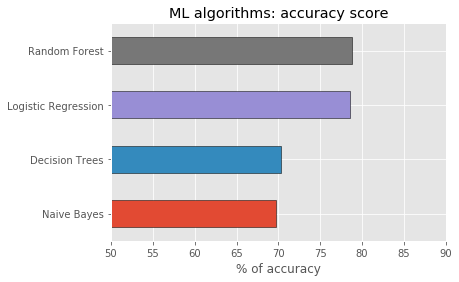

In [33]:
# Visualization of accuracy scores per model
models = ['Naive Bayes','Decision Trees','Random Forest','Logistic Regression']
accuracy = np.array([nb_accuracy, dt_accuracy, rf_accuracy, lr_accuracy])
accuracy = accuracy*100
accuracy_serie = pd.Series(accuracy, index=models).sort_values()
accuracy_serie.plot.barh(ec='black')
plt.title('ML algorithms: accuracy score')
plt.xlim(50,90)
plt.xlabel('% of accuracy')
plt.show()

- Accuracy scores obtained for RF and LR are significantly greater than DT and NB
- Both RF and LR classify test set observations correctly almost 4 over 5 of the times.

In [34]:
# Defining function for ROC curve plotting
from sklearn import metrics
def plot_model(name, model, color):
    if name == 'LR':
        probs = model.predict_proba(test_dum_predictors)
        probs = probs[:, 1] 
        auc = metrics.roc_auc_score(test_dum['income_cat'], probs)
        fpr, tpr, thresholds = metrics.roc_curve(test_dum['income_cat'], probs)
        plt.plot(fpr, tpr, color=color, label=name+' auc: %0.3f' %auc)
        plt.legend(loc="lower right")
    else:
        probs = model.predict_proba(test[test_predictors])
        probs = probs[:, 1]
        auc = metrics.roc_auc_score(test['income_cat'], probs)
        fpr, tpr, thresholds = metrics.roc_curve(test['income_cat'], probs)
        plt.plot(fpr, tpr, color=color, label=name+' auc: %0.3f' %auc, lw=3)
        plt.legend(loc="lower right")

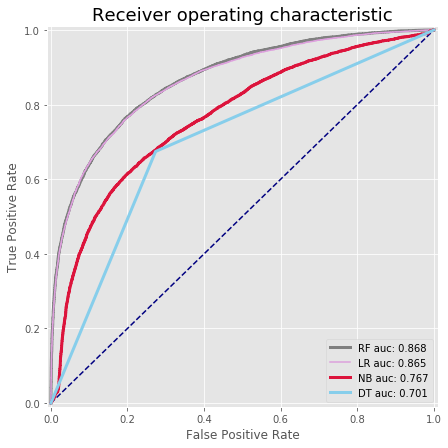

In [35]:
# Plotting ROC curves
plt.figure(figsize=(7,7))
# plot diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
# general graph definitions
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic', fontsize=18)
# calling function on each model
plot_model('RF', rf_model, 'grey')
plot_model('LR', lr_model, 'plum')
plot_model('NB', nb_model, 'crimson')
plot_model('DT', dt_model, 'skyblue')
plt.show()

- AUC scores of RF and LR can be classified as "good" results, while NB and DT could be classified as "fair"[1]
- We confirme that the performances of RF and LR are significantly better than NB and DT
***
[1] http://gim.unmc.edu/dxtests/roc3.htm

### Step 8: Feature importance analysis

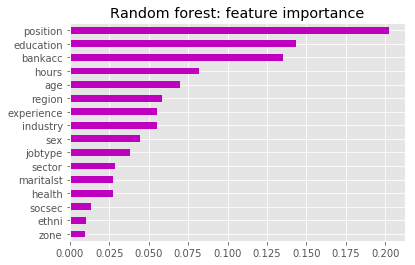

In [36]:
# RF feature importance
rf_importance = rf.feature_importances_
rf_importance = pd.Series(rf_importance, index=train.columns[:16]).sort_values()
rf_importance.plot.barh(color='m')
plt.title('Random forest: feature importance')
plt.show()

- 'position', 'education' and 'bankacc' were selected as the most important features in prediction by RF, confirming previous comments on the EDA step
- Although they did not seem helpful when EDA was performed, 'hours' and 'age' were selected as part of the top 5 of most important features
- 'ethni' and 'zone' were not relevant, confirming previous hipotesys

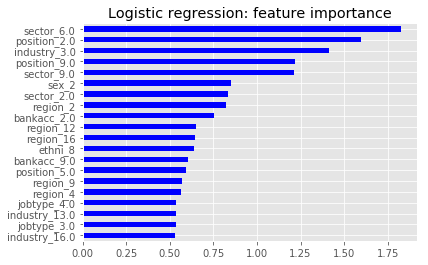

In [37]:
# LR feature importance
lr_coefficients = lr_model.coef_
lr_coefficients = pd.Series(lr_coefficients[0], index=train_dum_predictors.columns).abs()
lr_coefficients_largest = lr_coefficients.nlargest(n=20, keep='first').sort_values()
lr_coefficients_largest.plot.barh(color='blue')
plt.title('Logistic regression: feature importance')
plt.show()

Given the high number of features, the LR feature importance graph only shows the 20 most relevan features for prediction.
- 'sector' has tree options on the top 10 of features, being the most relevan selected by LR
- 'position' is also present tree times but in the top 15, so could be classified as the second most relevant


Next steps: 
- use some kind of string search for doing a summation of LR coefficients over all dummies
- RF grid search over trees and depth